In [1]:
# !pip install linermodels

In [2]:
import pandas as pd
import numpy as np
import polars as pl
import statsmodels.api as sm
import requests, zipfile, io
import calendar
# from linearmodels import PanelOLS
from pandas.tseries.offsets import MonthEnd, YearEnd
import matplotlib.pyplot as plt

In [4]:
df_forecasts = pl.read_parquet("results/composite_forecasts_origdata.parquet")
df_fundamental = pl.read_parquet("data/monthly_dataset.parquet")

In [ ]:

# Compute the last business day of March
def get_last_business_day(year):
    return pd.to_datetime(f"{year}-03-01") + pd.offsets.BMonthEnd()

# Add additional columns
df_forecasts = df_forecasts.with_columns([
    pl.col('year').alias('act_year'),
    pl.lit(3).alias('month_forecast'),
    (pl.col('year') + 1).alias('year'),
    pl.col('year').map_elements(get_last_business_day).alias('jdate'),
    (pl.col('year') + 1).map_elements(get_last_business_day).alias('forecast_jdate')
])

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


In [13]:
df_forecasts

gvkey,year,E,mkt_cap,E_future,E_pred_ols,E_pred_ann_bagging,E_pred_ar,E_pred_catboost,E_pred_gbf,E_pred_hvz,E_pred_lasso,E_pred_lightgbm,E_pred_rf,E_pred_ri,E_pred_ridge,E_pred_rw,abs_error_rw_scaled,E_pred_xgb,COMP_EXT,COMP_LR,COMP_NL,COMP_ML,abs_error_COMP_EXT_scaled,abs_error_COMP_LR_scaled,abs_error_COMP_NL_scaled,abs_error_COMP_ML_scaled,COMP_MED_EXT,COMP_MED_LR,COMP_MED_NL,COMP_MED_ML,abs_error_COMP_MED_EXT_scaled,abs_error_COMP_MED_LR_scaled,abs_error_COMP_MED_NL_scaled,abs_error_COMP_MED_ML_scaled,act_year,month_forecast,jdate,forecast_jdate
str,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i32,datetime[μs],datetime[μs]
"""001000""",1976,2.135,6.651,2.284,2.420133,2.263415,2.257448,1.583231,2.208044,1.54936,1.894656,1.866192,1.623853,2.799934,2.013623,2.135,0.022403,1.694751,2.202247,2.109471,1.873248,1.951989,0.012292,0.026241,0.061758,0.049919,2.257448,2.013623,1.780471,1.894656,0.003992,0.040652,0.075707,0.058539,1975,3,1975-03-31 00:00:00,1976-03-31 00:00:00
"""001004""",1976,2.105,6.60975,1.866,1.98028,2.127867,2.225728,2.550523,2.540045,3.374177,1.874821,2.216258,2.185605,2.875331,1.906874,2.105,0.036159,2.138542,2.825079,1.920658,2.29314,2.168979,0.145101,0.008269,0.064623,0.045838,2.875331,1.906874,2.200932,2.138542,0.152703,0.006184,0.050672,0.041233,1975,3,1975-03-31 00:00:00,1976-03-31 00:00:00
"""001010""",1976,28.776,231.4515,30.724,30.817959,25.88368,30.426387,27.515224,30.443014,30.795335,28.001621,32.371778,29.672857,32.603294,29.70504,28.776,0.008416,29.096701,31.275005,29.508207,29.163876,29.278653,0.002381,0.005253,0.006741,0.006245,30.795335,29.70504,29.384779,29.672857,0.000308,0.004402,0.005786,0.004542,1975,3,1975-03-31 00:00:00,1976-03-31 00:00:00
"""001019""",1976,0.327,3.4845,0.435,0.508251,0.496359,0.345754,0.198161,0.319722,1.986212,0.434045,0.415932,0.430383,0.969683,0.453228,0.327,0.030994,0.382141,1.10055,0.465175,0.373783,0.404247,0.191003,0.00866,0.017568,0.008826,0.969683,0.453228,0.399037,0.430383,0.153446,0.005231,0.010321,0.001325,1975,3,1975-03-31 00:00:00,1976-03-31 00:00:00
"""001020""",1976,-4.625,7.89075,-5.788,-3.182338,-0.144835,-4.890257,-1.364738,-0.148827,-2.9602,-3.480042,-0.688479,-1.06129,-1.256817,-3.513061,-4.625,0.147388,-1.903379,-3.035758,-3.391813,-0.885258,-1.720776,0.348793,0.30367,0.621328,0.515442,-2.9602,-3.480042,-0.874884,-1.364738,0.358369,0.292489,0.622642,0.560563,1975,3,1975-03-31 00:00:00,1976-03-31 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""176899""",2020,35.015,286.21776,-1441.28,22.500795,-9.224703,31.959146,9.810167,19.532289,85.81984,35.169524,28.99068,10.048837,67.838889,26.326147,35.015,5.157943,3.034987,61.872625,27.998822,10.365376,16.243191,5.25178,5.13343,5.071821,5.092358,67.838889,26.326147,9.929502,19.532289,5.272625,5.127586,5.070299,5.103849,2019,3,2019-03-29 00:00:00,2020-03-31 00:00:00
"""178851""",2020,-39.874,138.9735,-21.369,-29.250283,-9.946344,-36.394088,-14.60611,-16.642964,-22.198181,-26.938125,-12.040146,-5.31198,-38.091566,-27.015199,-39.874,0.133155,-10.542695,-32.227945,-27.734535,-11.51504,-16.921538,0.078137,0.045804,0.070905,0.032002,-36.394088,-27.015199,-11.291421,-14.60611,0.108115,0.040628,0.072514,0.048663,2019,3,2019-03-29 00:00:00,2020-03-31 00:00:00
"""179690""",2020,-17.73,6050.08736,47.408,154.827291,51.256297,-16.182655,-136.383035,-18.665854,52.816094,207.962743,-7.047964,-30.49708,30.002553,179.959263,-17.73,0.010766,-156.466767,22.211997,180.916432,-49.634067,27.216099,0.004165,0.022067,0.01604,0.003337,30.002553,179.959263,-24.581467,-7.047964,0.002877,0.021909,0.011899,0.009001,2019,3,2019-03-29 00:00:00,2020-03-31 00:00:00


Not enough gvkey data for 2024 yet

In [14]:
df_forecasts = df_forecasts.with_columns(
    pl.col("gvkey").cast(pl.Int64).cast(pl.Utf8).str.zfill(6)
)
df_fundamental = df_fundamental.with_columns(
    pl.col("gvkey").cast(pl.Int64).cast(pl.Utf8).str.zfill(6),
    pl.col("date").cast(pl.Date),
    pl.col("retadj_x").alias("retadj")
)
df_fundamental_subset = df_fundamental.select(["gvkey", "date", "sic", "retadj"])
df_fundamental_subset = df_fundamental_subset.filter(pl.col("date").dt.year() != 2024)

In [15]:
df_fundamental_subset = df_fundamental_subset.drop_nulls()

In [16]:
df_calendar = (
    df_fundamental_subset.select(
        pl.col("date"),
        pl.col("date").dt.year().alias("year"),
        pl.col("date").dt.month().alias("month")
    )
    .unique()
    .group_by(["year", "month"])
    .agg(pl.col("date").max().alias("date"))
    .sort(["year", "month"])
    .select(["year", "date"])
)

In [18]:
df_forecasts = df_forecasts.with_columns(
    pl.col("year").cast(pl.Int32)
)

df_calendar = df_calendar.with_columns(
    pl.col("year").cast(pl.Int32)
)

df_forecasts_monthly = df_forecasts.join(
    df_calendar, on="year", how="inner"
)

In [20]:
filtered_df = df_forecasts_monthly.filter(pl.col("gvkey") == "001000").head(14)

In [32]:
df_forecasts_monthly.filter(pl.col("gvkey") == "315318")['date', 'E_pred_ann_bagging'].head(20)

date,E_pred_ann_bagging
date,f64
2015-01-30,194.901838
2015-02-27,194.901838
2015-03-31,194.901838
2015-04-30,194.901838
2015-05-29,194.901838
…,…
2016-04-29,298.32601
2016-05-31,298.32601
2016-06-30,298.32601


In [187]:
df_merged = df_forecasts_monthly.join(
    df_fundamental_subset, on=["date", "gvkey"], how="inner"
)

In [188]:
# drop missing retadj values
df_merged = df_merged.filter(pl.col("retadj").is_not_null())
print("Number of missing retadj values: ", df_merged.filter(pl.col("retadj").is_null()).shape[0])

Number of missing retadj values:  0


In [190]:
null_counts = df_merged.null_count()
print(null_counts)

shape: (1, 42)
┌───────┬──────┬─────┬─────────┬───┬────────────────┬──────┬─────┬────────┐
│ gvkey ┆ year ┆ E   ┆ mkt_cap ┆ … ┆ forecast_jdate ┆ date ┆ sic ┆ retadj │
│ ---   ┆ ---  ┆ --- ┆ ---     ┆   ┆ ---            ┆ ---  ┆ --- ┆ ---    │
│ u32   ┆ u32  ┆ u32 ┆ u32     ┆   ┆ u32            ┆ u32  ┆ u32 ┆ u32    │
╞═══════╪══════╪═════╪═════════╪═══╪════════════════╪══════╪═════╪════════╡
│ 0     ┆ 0    ┆ 0   ┆ 0       ┆ … ┆ 0              ┆ 0    ┆ 0   ┆ 0      │
└───────┴──────┴─────┴─────────┴───┴────────────────┴──────┴─────┴────────┘


In [191]:
cols_to_keep = ['gvkey', 'year', 'E', 'mkt_cap', 'E_future', 'E_pred_ols', 'E_pred_ann_bagging', 'E_pred_ar', 'E_pred_catboost', 'E_pred_gbf', 
                'E_pred_hvz', 'E_pred_lasso', 'E_pred_lightgbm', 'E_pred_ri', 'E_pred_ridge', 'E_pred_rw', 'E_pred_xgb', 'COMP_EXT', 'COMP_LR', 
                'COMP_NL', 'COMP_ML', 'COMP_MED_EXT', 'COMP_MED_LR', 'COMP_MED_NL', 'COMP_MED_ML', 'date', 'sic', 'retadj']
df_merged = df_merged.select(cols_to_keep)

In [192]:
df_merged.head(1)

gvkey,year,E,mkt_cap,E_future,E_pred_ols,E_pred_ann_bagging,E_pred_ar,E_pred_catboost,E_pred_gbf,E_pred_hvz,E_pred_lasso,E_pred_lightgbm,E_pred_ri,E_pred_ridge,E_pred_rw,E_pred_xgb,COMP_EXT,COMP_LR,COMP_NL,COMP_ML,COMP_MED_EXT,COMP_MED_LR,COMP_MED_NL,COMP_MED_ML,date,sic,retadj
str,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,f64,f64
"""001801""",1976,5.567,72.75,10.146,6.251189,6.496482,5.886284,4.765938,5.803256,7.282882,6.036374,5.846079,6.872997,5.858734,5.567,5.152007,6.680721,6.048766,5.64346,5.778562,6.872997,6.036374,5.800128,5.846079,1976-01-30,2086.0,0.065041


In [193]:
# models = ['E_pred_ols',	'E_pred_ann_bagging', 'E_pred_catboost',	'E_pred_gbf', 'E_pred_lasso',	'E_pred_lightgbm', 'E_pred_ridge', 'E_pred_xgb', 'COMP_LR', 'COMP_NL', 'COMP_ML']

In [195]:
import statsmodels.api as sm

# List of model columns
models = ['E_pred_ols', 'E_pred_ann_bagging', 'E_pred_catboost',
          'E_pred_gbf', 'E_pred_lasso', 'E_pred_lightgbm',
          'E_pred_ridge', 'E_pred_xgb', 'COMP_LR', 'COMP_NL', 'COMP_ML']

# Function to compute residuals for each model
def compute_resid_info(subdf: pl.DataFrame, model_col: str) -> pl.DataFrame:
    X = subdf.select(["E_pred_rw", "COMP_EXT"]).to_pandas()
    y = subdf.select(model_col).to_pandas().squeeze()  # Dynamic y for each model
    X = sm.add_constant(X)
    
    # Fit OLS model and compute residuals
    model = sm.OLS(y, X).fit()
    residuals = model.resid.values  

    # Replace the original model column with its residuals
    return subdf.with_columns(pl.Series(model_col, residuals))

# Iteratively calculate residuals for all models
dfs = []
for date_val, group_df in df_merged.group_by("date"):
    for model_col in models:
        group_df = compute_resid_info(group_df, model_col)
    dfs.append(group_df)

# Combine the data back into one DataFrame
df_merged = pl.concat(dfs)


In [196]:
df_merged.head(2)

gvkey,year,E,mkt_cap,E_future,E_pred_ols,E_pred_ann_bagging,E_pred_ar,E_pred_catboost,E_pred_gbf,E_pred_hvz,E_pred_lasso,E_pred_lightgbm,E_pred_ri,E_pred_ridge,E_pred_rw,E_pred_xgb,COMP_EXT,COMP_LR,COMP_NL,COMP_ML,COMP_MED_EXT,COMP_MED_LR,COMP_MED_NL,COMP_MED_ML,date,sic,retadj
str,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,f64,f64
"""009613""",1991,68.047,624.453,69.553,6.969436,-23.781863,66.511843,-10.865788,0.416186,66.946876,1.603141,-10.486102,67.365425,1.787702,68.047,-4.75827,66.941381,3.453427,-9.47322,-5.164338,66.946876,59.108806,54.008037,57.765914,1991-07-31,7340.0,0.105505
"""002812""",1991,94.924,2051.39275,120.455,-38.953071,-18.185246,92.782491,-30.941636,-12.375296,93.482609,-36.688116,-25.456374,96.760617,-38.180724,94.924,-40.978041,94.341906,-37.940637,-26.232476,-30.135196,93.482609,57.80375,66.624197,59.441801,1991-07-31,100.0,0.152597


In [197]:
def load_ff3_factors_local(filepath="F-F_Research_Data_Factors.CSV"):
    """
    Loads and processes the Fama-French 3-factor file (plus RF) 
    """
    df = pd.read_csv(filepath, skiprows=3)
    
    df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    for col in ["Mkt-RF", "SMB", "HML", "RF"]:
        df[col] = pd.to_numeric(df[col], errors="coerce") / 100
    
    df.rename(columns={"Mkt-RF": "Mkt_RF"}, inplace=True)
    
    return df

def load_ff5_factors_local(filepath="F-F_Research_Data_5_Factors_2x3.CSV"):
    """
    Loads and processes the Fama-French 5-factor file (plus RF).
    """
    df = pd.read_csv(filepath, skiprows=3)
    
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    df.rename(columns={"Mkt-RF": "Mkt_RF"}, inplace=True)
    
    factor_cols = ["Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF"]
    for col in factor_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce") / 100 
    
    return df

def load_momentum_factor_local(filepath="F-F_Momentum_Factor.CSV"):
    """
    Loads and processes the Momentum factor file.
    """
    df = pd.read_csv(filepath, skiprows=13)

    df.columns = df.columns.str.strip()
    
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    df["Mom"] = pd.to_numeric(df["Mom"], errors="coerce") / 100
    
    return df

In [206]:
import polars as pl
import statsmodels.api as sm
import numpy as np

# List of model columns
models = ['E_pred_ols', 'E_pred_ann_bagging', 'E_pred_catboost',
          'E_pred_gbf', 'E_pred_lasso', 'E_pred_lightgbm',
          'E_pred_ridge', 'E_pred_xgb', 'COMP_LR', 'COMP_NL', 'COMP_ML']

# Function to compute residuals for each model
def compute_resid_info(subdf: pl.DataFrame, model_col: str) -> pl.DataFrame:
    X = subdf.select(["E_pred_rw", "COMP_EXT"]).to_pandas()
    y = subdf.select(model_col).to_pandas().squeeze()  
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    residuals = model.resid.values  

    # Replace model column values with residuals
    return subdf.with_columns(pl.Series(model_col, residuals))

# Compute residuals
dfs = []
for date_val, group_df in df_merged.group_by("date"):
    for model_col in models:
        group_df = compute_resid_info(group_df, model_col)
    dfs.append(group_df)

df_merged = pl.concat(dfs)

# Create quintiles for each model's residuals
for model_col in models:
    df_merged = df_merged.with_columns(
        pl.when(pl.col(model_col) <= pl.col(model_col).quantile(0.2)).then(1)
        .when(
            (pl.col(model_col) > pl.col(model_col).quantile(0.2)) & 
            (pl.col(model_col) <= pl.col(model_col).quantile(0.4))
        ).then(2)
        .when(
            (pl.col(model_col) > pl.col(model_col).quantile(0.4)) & 
            (pl.col(model_col) <= pl.col(model_col).quantile(0.6))
        ).then(3)
        .when(
            (pl.col(model_col) > pl.col(model_col).quantile(0.6)) & 
            (pl.col(model_col) <= pl.col(model_col).quantile(0.8))
        ).then(4)
        .otherwise(5)  # Values greater than Q4 go to Quintile 5
        .alias(f"{model_col}_quintile")
    )


In [207]:


# # Portfolio Return Calculation Function
# def calculate_portfolio_returns(df, model_col, weight_col=None):
#     quintile_returns = df.group_by(["date", f"{model_col}_quintile"]).agg(
#         pl.col("retadj").mean().alias("mean_ret"),
#         pl.sum(weight_col).alias("total_weight") if weight_col else None
#     )

#     # Calculate Hedge Portfolio Returns (Quintile 5 - Quintile 1)
#     portfolio_rets = (
#         quintile_returns
#         .filter(pl.col(f"{model_col}_quintile").is_in([1, 5]))
#         .pivot(values="mean_ret", index="date", columns=f"{model_col}_quintile")
#         .with_columns(
#             (pl.col("5").cast(float) - pl.col("1").cast(float)).alias(f"{model_col}")
#         )
#         .select(["date", f"{model_col}"])
#     )

#     return portfolio_rets

# # Alpha Calculation
# def estimate_alpha(returns, factors):
#     X = sm.add_constant(factors)
#     y = returns

#     model = sm.OLS(y, X).fit()
#     return model.params[1], model.tvalues[1]  # Alpha and its t-stat

# # # Summary Table Construction
# # summary_results = []
# # ff3_factors = load_ff3_factors_local("data/F-F_Research_Data_Factors.CSV")
# # capm_factors = ff3_factors[['Date', 'Mkt_RF', 'RF']]
# # ff5_factors = load_ff5_factors_local("data/F-F_Research_Data_5_Factors_2x3.CSV")
# # carhart_factors = load_momentum_factor_local("data/F-F_Momentum_Factor.CSV")


In [208]:
df_merged_act = df_merged.clone()

In [209]:
df_merged['date'].max()

datetime.date(2018, 12, 1)

In [210]:
df_merged = df_merged.filter(
    pl.col("date") < pl.datetime(2019,1,1)
)

In [211]:
df_merged['date'].max()

datetime.date(2018, 12, 1)

In [234]:
import polars as pl
import statsmodels.api as sm
import numpy as np


# Portfolio Return Calculation Function (with Market Cap Weighting Support)
def calculate_portfolio_returns(df, model_col, weight_col=None):
    # Calculate weighted mean returns for each quintile
    if weight_col:
        quintile_returns = df.group_by(["date", f"{model_col}_quintile"]).agg(
            ((pl.col("retadj") * pl.col(weight_col)).sum() / pl.col(weight_col).sum())
            .alias("weighted_mean_ret"),
            pl.sum(weight_col).alias("total_weight")
        )
        mean_ret_col = "weighted_mean_ret"
    else:
        quintile_returns = df.group_by(["date", f"{model_col}_quintile"]).agg(
            pl.col("retadj").mean().alias("mean_ret")
        )
        mean_ret_col = "mean_ret"

    # Calculate Hedge Portfolio Returns (Quintile 5 - Quintile 1)
    portfolio_rets = (
        quintile_returns
        .filter(pl.col(f"{model_col}_quintile").is_in([1, 5]))
        .pivot(values=mean_ret_col, index="date", columns=f"{model_col}_quintile")
        .with_columns(
            (pl.col("5").cast(float) - pl.col("1").cast(float)).alias(f"{model_col}")
        )
        .select(["date", f"{model_col}"])
    )

    return portfolio_rets

# Alpha Calculation (Now Uses Inner Join on Dates)
model_params = {}
def estimate_alpha(returns_df, factors_df):
    # Perform inner join on date for alignment
    # print(returns_df)
    # print("factors")
    # print(factors_df)
    returns_df = returns_df.with_columns(
    pl.col("date").cast(pl.Datetime("ns"))
)
    returns_df = returns_df.sort("date")
    factors_df = factors_df.sort("Date")

    merged_data = returns_df.join(factors_df, left_on='date', right_on='Date', how='inner')
    if returns_df.columns[1] == 'E_pred_catboost':
        print('returns')
        print(returns_df)
        print('factors')
        print(factors_df)
        # Drop all rows with NaN values
        merged_data = merged_data.drop_nulls()
    
    # print("merged_data")
    # print(merged_data)
    # Ensure correct structure for regression
    # print("ycol")
    # print(returns_df.columns[1])
    
    y = merged_data.select(returns_df.columns[1]).to_numpy().flatten()  # Portfolio Returns
    # print("y")
    # print(y)
    X = merged_data.select([col for col in factors_df.columns if col != 'Date']).to_numpy()
    # print('x')
    # print(X)
    X = sm.add_constant(X)  # Add intercept

    # Fit OLS regression for Alpha calculation
    model = sm.OLS(y, X).fit()
    # print(model.params)

    if returns_df.columns[1] == 'E_pred_catboost':
        print(model.params)
        print("merged_data")
        print(merged_data)
    
    factormodel = (
    'capm' if len(factors_df.columns) == 3 else
    'ff3' if len(factors_df.columns) == 5 else
    'ff5' if len(factors_df.columns) == 7 else
    'carhart' if len(factors_df.columns) == 6 else
    'unknown')
    model_params[returns_df.columns[1]+'_'+factormodel] = (model.params, model.tvalues, model)

    return model.params[0], model.tvalues[0]  # Alpha and its t-stat

# Summary Table Construction
summary_results = []


# Load factor data using pandas
ff3_factors = load_ff3_factors_local("data/F-F_Research_Data_Factors.CSV")
capm_factors = ff3_factors[['Date', 'Mkt_RF', 'RF']]
ff5_factors = load_ff5_factors_local("data/F-F_Research_Data_5_Factors_2x3.CSV")
carhart_factors = load_momentum_factor_local("data/F-F_Momentum_Factor.CSV")
carhart_factors = carhart_factors.merge(ff3_factors, on = "Date", how = 'inner')

ff3_factors['Date'] = pd.to_datetime(ff3_factors['Date'])
capm_factors['Date'] = pd.to_datetime(capm_factors['Date'])
ff5_factors['Date'] = pd.to_datetime(ff5_factors['Date'])
carhart_factors['Date'] = pd.to_datetime(carhart_factors['Date'])

# Convert back to Polars for compatibility with the rest of your code
ff3_factors = pl.from_pandas(ff3_factors)
capm_factors = pl.from_pandas(capm_factors)
ff5_factors = pl.from_pandas(ff5_factors)
carhart_factors = pl.from_pandas(carhart_factors)

# print(ff3_factors.head(1))

# df_merged = df_merged.with_columns(
#     pl.col("date").str.to_datetime("%Y-%m-%d").dt.convert_time_unit("ns")
# )

df_merged = df_merged.with_columns(
    pl.col("date").dt.truncate("1mo")
)
for model_col in models:
    eq_weighted_rets = calculate_portfolio_returns(df_merged, model_col)
    vw_weighted_rets = calculate_portfolio_returns(df_merged, model_col, weight_col="mkt_cap")

    if model_col == 'E_pred_ann_bagging':
        vw_ann = vw_weighted_rets.to_pandas()
        eq_ann = eq_weighted_rets.to_pandas()

    # print("eq wtd rets")
    # print(eq_weighted_rets)
#     eq_weighted_rets = eq_weighted_rets.with_columns(
#     pl.col("date").str.to_datetime("%Y-%m-%d")
# )

#     vw_weighted_rets = vw_weighted_rets.with_columns(
#     pl.col("date").str.to_datetime("%Y-%m-%d")
# )

    # CAPM Alpha Calculation
    capm_alpha, capm_tstat = estimate_alpha(eq_weighted_rets, capm_factors)
    capm_alpha_vw, capm_tstat_vw = estimate_alpha(vw_weighted_rets, capm_factors)

    # FF3 Alpha Calculation
    ff3_alpha, ff3_tstat = estimate_alpha(eq_weighted_rets, ff3_factors)
    ff3_alpha_vw, ff3_tstat_vw = estimate_alpha(vw_weighted_rets, ff3_factors)

    # Carhart 4-factor Alpha
    carhart_alpha, carhart_tstat = estimate_alpha(eq_weighted_rets, carhart_factors)
    carhart_alpha_vw, carhart_tstat_vw = estimate_alpha(vw_weighted_rets, carhart_factors)

    # FF5 Alpha Calculation
    ff5_alpha, ff5_tstat = estimate_alpha(eq_weighted_rets, ff5_factors)
    ff5_alpha_vw, ff5_tstat_vw = estimate_alpha(vw_weighted_rets, ff5_factors)

    # Collect results
    summary_results.append({
        'Model': model_col,
        'Mean Return': eq_weighted_rets[model_col].mean(),
        'VW Mean Return': vw_weighted_rets[model_col].mean(),
        'CAPM Alpha': capm_alpha,
        'CAPM Alpha VW': capm_alpha_vw,
        'CAPM t-stat': capm_tstat,
        'CAPM t-stat VW': capm_tstat_vw,
        'FF3 Alpha': ff3_alpha,
        'FF3 Alpha VW': ff3_alpha_vw,
        'FF3 t-stat': ff3_tstat,
        'FF3 t-stat VW': ff3_tstat_vw,
        'Carhart4 Alpha': carhart_alpha,
        'Carhart4 Alpha VW': carhart_alpha_vw,
        'Carhart4 t-stat': carhart_tstat,
        'Carhart4 t-stat VW': carhart_tstat_vw,
        'FF5 Alpha': ff5_alpha,
        'FF5 Alpha VW': ff5_alpha_vw,
        'FF5 t-stat': ff5_tstat,
        'FF5 t-stat VW': ff5_tstat_vw,
    })

# Convert to DataFrame for Presentation
summary_df = pl.DataFrame(summary_results)
summary_df


C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capm_factors['Date'] = pd.to_datetime(capm_factors['Date'])
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_retur

returns
shape: (516, 2)
┌─────────────────────┬─────────────────┐
│ date                ┆ E_pred_catboost │
│ ---                 ┆ ---             │
│ datetime[ns]        ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 1976-01-01 00:00:00 ┆ 0.049392        │
│ 1976-02-01 00:00:00 ┆ -0.090094       │
│ 1976-03-01 00:00:00 ┆ 0.061824        │
│ 1976-04-01 00:00:00 ┆ 0.025082        │
│ 1976-05-01 00:00:00 ┆ 0.006978        │
│ …                   ┆ …               │
│ 2018-08-01 00:00:00 ┆ -0.016234       │
│ 2018-09-01 00:00:00 ┆ 0.027321        │
│ 2018-10-01 00:00:00 ┆ 0.027636        │
│ 2018-11-01 00:00:00 ┆ 0.022406        │
│ 2018-12-01 00:00:00 ┆ 0.010647        │
└─────────────────────┴─────────────────┘
factors
shape: (1_182, 3)
┌─────────────────────┬─────────┬────────┐
│ Date                ┆ Mkt_RF  ┆ RF     │
│ ---                 ┆ ---     ┆ ---    │
│ datetime[ns]        ┆ f64     ┆ f64    │
╞═════════════════════╪═════════╪════════╡
│ 1926-07-01 00:00:00

C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Local\Temp\ipykernel_4288\1048867974.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  quintile_returns
C:\Users\shaya\AppData\Lo

Model,Mean Return,VW Mean Return,CAPM Alpha,CAPM Alpha VW,CAPM t-stat,CAPM t-stat VW,FF3 Alpha,FF3 Alpha VW,FF3 t-stat,FF3 t-stat VW,Carhart4 Alpha,Carhart4 Alpha VW,Carhart4 t-stat,Carhart4 t-stat VW,FF5 Alpha,FF5 Alpha VW,FF5 t-stat,FF5 t-stat VW
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""E_pred_ols""",0.000667,0.000052,-0.000617,-0.001506,-0.446868,-1.137219,-0.000622,-0.001551,-0.451625,-1.175285,-0.000501,-0.001307,-0.363697,-0.999661,0.000219,-0.000911,0.158141,-0.682741
"""E_pred_ann_bagging""",0.001616,0.001551,0.00075,0.001287,0.468463,0.877824,0.00031,0.001214,0.199164,0.829081,-0.000027,0.001212,-0.017625,0.825845,-0.000218,0.001323,-0.139963,0.892198
"""E_pred_catboost""",0.000195,0.000742,-0.000536,0.002615,-0.173312,0.986117,-0.000864,0.002575,-0.302913,0.974206,-0.001088,0.002273,-0.384557,0.876199,-0.002063,0.002966,-0.724193,1.119256
"""E_pred_gbf""",0.00111,-0.000051,0.000616,-0.0022,0.303635,-1.454043,0.001085,-0.001653,0.561453,-1.153578,0.001325,-0.001842,0.687729,-1.289273,-0.000353,-0.00203,-0.190446,-1.39551
"""E_pred_lasso""",0.000918,0.000776,-0.000287,-0.000018,-0.219762,-0.014158,-0.000388,-0.000151,-0.306837,-0.118638,-0.000423,-0.000048,-0.333903,-0.037454,0.000148,0.000248,0.115828,0.192175
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""E_pred_ridge""",0.001093,0.000463,-0.000768,-0.000848,-0.577564,-0.662863,-0.000769,-0.000916,-0.58318,-0.718293,-0.000739,-0.000715,-0.558862,-0.564112,-0.000015,-0.000297,-0.011208,-0.230214
"""E_pred_xgb""",-0.000443,-0.001186,0.000335,-0.001746,0.193799,-1.135114,0.000594,-0.001344,0.354022,-0.901418,0.000255,-0.00161,0.153605,-1.089153,0.001427,-0.00116,0.845815,-0.765006
"""COMP_LR""",0.001008,0.000509,-0.000787,-0.000946,-0.594541,-0.732897,-0.000764,-0.001018,-0.580977,-0.791654,-0.000745,-0.000876,-0.565061,-0.682539,-0.00004,-0.000528,-0.030512,-0.405388


In [239]:
model_params['E_pred_ann_bagging_ff3'][2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     8.971
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           5.23e-07
Time:                        08:28:18   Log-Likelihood:                 1278.8
No. Observations:                 516   AIC:                            -2548.
Df Residuals:                     511   BIC:                            -2526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.829      0.407      -0.002       0.004
x1             0.0992      0.022      4.575      0.000       0.057       0.142
x2             0.0628      0.032      1.993      0.047       0.001       0.125
x3            -0.0216      0.033     -0.655      0.513      -0.086       0.043
x4            -0.0981      0.308     -0.318      0.751      -0.704       0.508
==============================================================================
Omnibus:                       43.546   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.153
Skew:                           0.253   Prob(JB):                     5.05e-37
Kurtosis:                       5.742   Cond. No.                         344.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
vw_ann2 = vw_ann.sort_values('date').set_index('date')
vw_ann2 = (1+vw_ann2).cumprod()
vw_ann2

,E_pred_ann_bagging
date,
1976-01-01,1.013109
1976-02-01,1.035669
1976-03-01,1.038358
1976-04-01,1.065847
1976-05-01,1.101088
...,...
2018-08-01,1.892722
2018-09-01,1.922000
2018-10-01,1.928522


In [214]:
import numpy as np
import pandas as pd

# Performance Metrics Calculation
def calculate_performance_metrics(rets, risk_free_rate=0.0):  
    # Calculate cumulative returns from the given series
    cumulative_returns = rets / rets.iloc[0]  # Ensure index starts at 1.0

    # Calculate CAGR
    total_years = (rets.index[-1] - rets.index[0]).days / 365.25
    print(f"total years = {total_years}")
    cagr = (cumulative_returns.iloc[-1]) ** (1 / total_years) - 1

    # Calculate Drawdown
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # Calculate Sharpe Ratio
    annualized_volatility = rets.pct_change().std() * np.sqrt(12)  # Monthly returns
    excess_return = cumulative_returns.iloc[-1] - 1
    sharpe_ratio = (cagr - risk_free_rate) / annualized_volatility

    # Calculate Sortino Ratio
    downside_returns = rets.pct_change().clip(upper=0)  # Only negative returns
    downside_volatility = downside_returns.std() * np.sqrt(12)
    sortino_ratio = (cagr - risk_free_rate) / downside_volatility

    # Display Results
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio
    }
    
    return pd.DataFrame(metrics, index=[0])

# Example Usage
rets = vw_ann2.loc[:"2019-01-01"]["E_pred_ann_bagging"]
performance_metrics = calculate_performance_metrics(rets)

print("Performance Metrics")
print(performance_metrics)


total years = 42.91581108829569
Performance Metrics
       CAGR  Max Drawdown  Sharpe Ratio  Sortino Ratio
0  0.015821      -0.39828      0.217144       0.384179


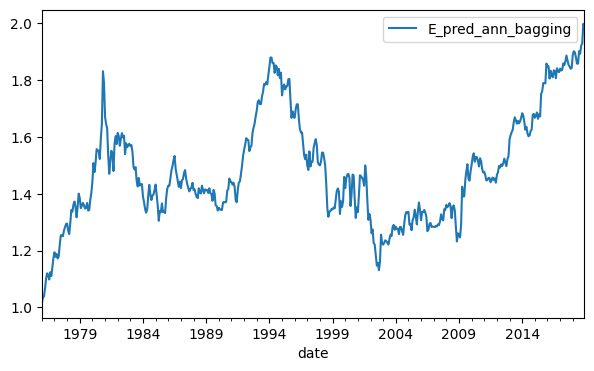

In [219]:
rets = vw_ann2.loc[:"2019-01-01"].plot(figsize = (7,4))


In [88]:
summary_df.to_pandas().to_csv('summary_df.csv')

In [235]:
import pandas as pd

summary_df_pd = summary_df.to_pandas()
# Extract Panel A (Equal-Weighted) and Panel B (Value-Weighted) Data
panel_a = summary_df_pd.rename(columns={
    'Mean Return': 'Mean Return (EW)',
    'CAPM Alpha': 'CAPM Alpha (EW)',
    'CAPM t-stat': 'CAPM t-stat (EW)',
    'FF3 Alpha': 'FF3 Alpha (EW)',
    'FF3 t-stat': 'FF3 t-stat (EW)',
    'Carhart4 Alpha': 'Carhart4 Alpha (EW)',
    'Carhart4 t-stat': 'Carhart4 t-stat (EW)',
    'FF5 Alpha': 'FF5 Alpha (EW)',
    'FF5 t-stat': 'FF5 t-stat (EW)'
})[[
    'Model', 'Mean Return (EW)', 'CAPM Alpha (EW)', 'CAPM t-stat (EW)',
    'FF3 Alpha (EW)', 'FF3 t-stat (EW)',
    'Carhart4 Alpha (EW)', 'Carhart4 t-stat (EW)',
    'FF5 Alpha (EW)', 'FF5 t-stat (EW)'
]]

panel_b = summary_df_pd.rename(columns={
    'VW Mean Return': 'Mean Return (VW)',
    'CAPM Alpha VW': 'CAPM Alpha (VW)',
    'CAPM t-stat VW': 'CAPM t-stat (VW)',
    'FF3 Alpha VW': 'FF3 Alpha (VW)',
    'FF3 t-stat VW': 'FF3 t-stat (VW)',
    'Carhart4 Alpha VW': 'Carhart4 Alpha (VW)',
    'Carhart4 t-stat VW': 'Carhart4 t-stat (VW)',
    'FF5 Alpha VW': 'FF5 Alpha (VW)',
    'FF5 t-stat VW': 'FF5 t-stat (VW)'
})[[
    'Model', 'Mean Return (VW)', 'CAPM Alpha (VW)', 'CAPM t-stat (VW)',
    'FF3 Alpha (VW)', 'FF3 t-stat (VW)',
    'Carhart4 Alpha (VW)', 'Carhart4 t-stat (VW)',
    'FF5 Alpha (VW)', 'FF5 t-stat (VW)'
]]

# Display Results
print("\n" + "="*40)
print("PANEL A: Equal-Weighted Portfolios")
print(panel_a.to_string(index=False))

print("\n" + "="*40)
print("PANEL B: Value-Weighted Portfolios")
print(panel_b.to_string(index=False))



PANEL A: Equal-Weighted Portfolios
             Model  Mean Return (EW)  CAPM Alpha (EW)  CAPM t-stat (EW)  FF3 Alpha (EW)  FF3 t-stat (EW)  Carhart4 Alpha (EW)  Carhart4 t-stat (EW)  FF5 Alpha (EW)  FF5 t-stat (EW)
        E_pred_ols          0.000667        -0.000617         -0.446868       -0.000622        -0.451625            -0.000501             -0.363697        0.000219         0.158141
E_pred_ann_bagging          0.001616         0.000750          0.468463        0.000310         0.199164            -0.000027             -0.017625       -0.000218        -0.139963
   E_pred_catboost          0.000195        -0.000536         -0.173312       -0.000864        -0.302913            -0.001088             -0.384557       -0.002063        -0.724193
        E_pred_gbf          0.001110         0.000616          0.303635        0.001085         0.561453             0.001325              0.687729       -0.000353        -0.190446
      E_pred_lasso          0.000918        -0.000287      

In [237]:
panel_a.to_csv('results/panel_a_results_2019_up.csv')
panel_b.to_csv('results/panel_b_results_2019_up.csv')